In [2]:
## Standard Stuff
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import dask.array as da
import numcodecs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import easygems.remap as egr

import intake     # For catalogs
import zarr       

In [3]:
catfn='/home/tmerlis/hackathon/xsh24_scream_main.yaml'

combo_cat = intake.open_catalog(catfn)

# 'coarse' is an online coarse-graining of 8 neighboring grid cells ~25km
# xsh24 = X-SHiELD 2024 model version, unpublished
# xsh21 = X-SHiELD 2021 model version, many articles including Cheng et al. 2022 GRL
print (list(combo_cat)) 

['xsh24_coarse', 'xsh24_native', 'xsh21_coarse', 'scream2D_hrly', 'scream_ne120', 'scream_lnd']


In [68]:
# select zoom level and the part of the combined catalog you're interested in
# coarse stores are available at zoom 7 ~50km and lower
zoom_select = 6
ds = combo_cat.xsh24_coarse(zoom=zoom_select).to_dask()
# attach coordinates; otherwise can't use lat and lon and selecting regions or taking a zonal mean won't work
ds = ds.pipe(egh.attach_coords)

# native stores are available at zoom 10 ~6.4km and lower, fewer variables and all are 2d
zoom_select_dsn = 5
dsn = combo_cat.xsh24_native(zoom=zoom_select_dsn).to_dask()
dsn = dsn.pipe(egh.attach_coords)

dsn_hr = combo_cat.xsh24_native(zoom=8).to_dask()
dsn_hr = dsn_hr.pipe(egh.attach_coords)


# we downloaded output from DOE's SCREAM model to stellar
# conceivably, we could add to our local collection of models during the week
# or augment the catalog with observational datasets
ds_scream = combo_cat.scream_ne120(zoom=zoom_select).to_dask()
ds_scream = ds_scream.pipe(egh.attach_coords)

/home/rv5936/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/rv5936/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),
/home/rv5936/.conda/envs/easy25/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping 

In [69]:
def worldmap(var, **kwargs):
    #projection = ccrs.Robinson(central_longitude=-135.5808361)
    projection = ccrs.Robinson(central_longitude=0)
    fig, ax = plt.subplots(
        figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
    )
    ax.set_global()
    # ax.add_feature(cf.COASTLINE, linewidth=0.8)
    hpshow = egh.healpix_show(var, ax=ax, **kwargs)
    cbar = plt.colorbar(hpshow, ax=ax, orientation='vertical', 
                    pad=0.05, shrink=0.8)


In [70]:
daily_cape_max    = dsn['CAPE_max'].sel(time=slice('2020-01-01','2020-12-31')).groupby('time.dayofyear').max('time')
daily_cape_max_hr = dsn_hr['CAPE_max'].sel(time=slice('2020-01-01','2020-12-31')).groupby('time.dayofyear').max('time')

<h4>Three Regions</h4>

Following: https://easy.gems.dkrz.de/Processing/healpix/limited_area_healpix.html

In [71]:
def get_axis_la(extent, subplot_kw=None):
    """Create cartopy.GeoAxis limited area with for a given extent."""
    if not subplot_kw:
        subplot_kw = {"projection": ccrs.PlateCarree()}
        
    fig, ax = plt.subplots(subplot_kw=subplot_kw)
    # ax.coastlines()
    ax.set_extent(extent)
    
    return fig, ax

In [72]:
north_america = [-110, -60, 25, 65]
se_australia  = [140, 170, -50, -20]
arabian_sea   = [35, 60, 10, 35]

In [81]:
order = zoom_select_dsn
def get_icells(extent,order):

    nside = hp.order2nside(order)
    npix = hp.nside2npix(nside)
    
    hp_lon, hp_lat = hp.pix2ang(nside, np.arange(npix), nest=True, lonlat=True)
    hp_lon = (hp_lon + 180) % 360 - 180

    icells, = np.where(
        (hp_lon > extent[0]) &
        (hp_lon < extent[1]) &
        (hp_lat > extent[2]) &
        (hp_lat < extent[3]))
    
    return icells

In [84]:
filter_dsn = lambda da, extent, zoom: da.isel(cell=get_icells(extent, zoom))

In [83]:
na_cape = filter_dsn(daily_cape_max, north_america, zoom_select_dsn).compute()
au_cape = filter_dsn(daily_cape_max, se_australia, zoom_select_dsn).compute()
as_cape = filter_dsn(daily_cape_max, arabian_sea, zoom_select_dsn).compute()

na_cape_hr = filter_dsn(daily_cape_max_hr, north_america, 8).compute()
au_cape_hr = filter_dsn(daily_cape_max_hr, se_australia, 8).compute()
as_cape_hr = filter_dsn(daily_cape_max_hr, arabian_sea, 8).compute()

In [85]:
get_quantile = lambda da, q: xr.apply_ufunc(lambda da, q: np.quantile(da, q, axis=1), da, q,
                                            input_core_dims =[['cell', 'dayofyear'], []], 
                                            output_core_dims=[['cell']])

In [97]:
ncases = 25

stacked = lambda da: da.stack(case=['cell','dayofyear'])

na_cases = stacked(na_cape).sortby(stacked(na_cape),ascending=False).isel(case=np.arange(ncases))
au_cases = stacked(au_cape).sortby(stacked(au_cape),ascending=False).isel(case=np.arange(ncases))
as_cases = stacked(as_cape).sortby(stacked(as_cape),ascending=False).isel(case=np.arange(ncases))

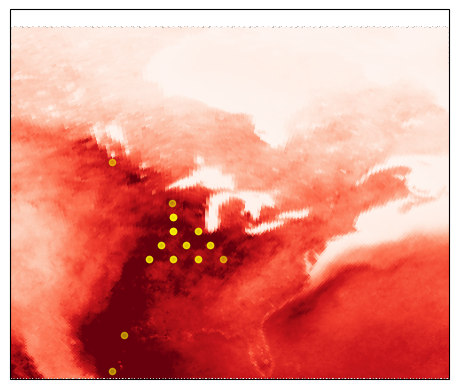

In [101]:
# This plots the entire world and then only shows a subset. So it's slower than sub-selecting the data first and then plotting

fig, ax = get_axis_la(north_america, subplot_kw={'projection': ccrs.PlateCarree()})
egh.healpix_show(get_quantile(na_cape_hr,0.97), ax=ax, cmap='Reds', vmin=0, vmax=3000)
ax.scatter(na_cases.lon, na_cases.lat, transform=ccrs.PlateCarree(), s=20, color='yellow', alpha=0.5)
# ax.coastlines()

# ax.set_global()
# ax.scatter(-100, 45, transform=ccrs.PlateCarree())
# plt.show()

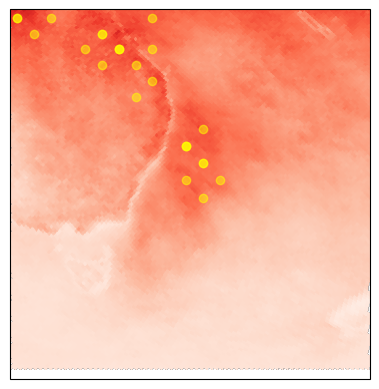

In [102]:
# This plots the entire world and then only shows a subset. So it's slower than sub-selecting the data first and then plotting

fig, ax = get_axis_la(se_australia, subplot_kw={'projection': ccrs.PlateCarree()})
egh.healpix_show(get_quantile(au_cape_hr,0.97), ax=ax, cmap='Reds', vmin=0, vmax=3000)
ax.scatter(au_cases.lon, au_cases.lat, transform=ccrs.PlateCarree(), color='yellow', alpha=0.5)

plt.show()

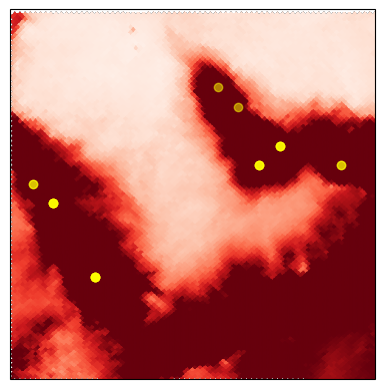

In [103]:
# This plots the entire world and then only shows a subset. So it's slower than sub-selecting the data first and then plotting

fig, ax = get_axis_la(arabian_sea, subplot_kw={'projection': ccrs.PlateCarree()})
egh.healpix_show(get_quantile(as_cape_hr,0.97), ax=ax, cmap='Reds', vmin=0, vmax=3000)
ax.scatter(as_cases.lon, as_cases.lat, transform=ccrs.PlateCarree(), color='yellow', alpha=0.5)

plt.show()